<a href="https://colab.research.google.com/github/shatoya777/coding-interview-university/blob/main/AI4ALL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Action Items:
1. Understand how its clustering/grouping these movies by tone. Also figure if there is a better way to scroe the sentiment of the overviews besides just positive/negative/neutral **(Simon)**
2. Get visualization of the clusters with Matplotlib going correct **(Simon)**
3. Accounting for BIAS: Maybe take what we said in the document/slides to counteract the bias and then implement it. Such as taking from the TMDb API and adding more movies to the dataset with different languages/countries of origin. Also make sure the reccommendation is randomizing the movies on release year and is not biased towards earlier release years.
4. Fix the 67K rows with the DF.
5. Complete EDA, feature importance, and model evaluation (On the slides week 8) **(Shatoya)**
6. Check with Rutendo on what to do for training and testing since our model isn't supervised learning. (Also check in with her to review our code).
7. (Optional) test how the model works now that we don't need to preprocess the text using VADER. Maybe work on a separate colab for this so there isn't any overwrite.

In [1]:
!pip install kagglehub[pandas-datasets]
!pip install vaderSentiment
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


# Installing Necessary Dependencies and Loading Dataset

In [2]:
# Install dependencies as needed:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import warnings
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA




file_path = "tmdb_5000_movies.csv"

#Loading the 5000 TMDb database
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,
                                "tmdb/tmdb-movie-metadata",
                                file_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-2-3511607662.py:27: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,


# Feature Selection

In [3]:
# For this project we are only concerning ourselves with the genres, id, original_title, overview
# and release_date (specifically the year)

#Dropping duplicates
df.drop_duplicates(subset=['original_title'],keep='first',inplace=True)

#Dropping unnecessary features (+ keeping some aditional ones for future use)
df.drop(df.columns.difference(['genres','id','original_title','overview',
                               'keywords','production_countries', 'runtime', 'release_date', 'spoken_languages', 'vote_average']),
                              axis=1, inplace=True)

#dropping any rows with null values for overview
df.dropna(subset=['overview'], inplace=True)

print(df.loc[0, 'genres'])

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]


# Preprocessing and vectorizing the overviews

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenizing the overview column

df['tokenized_overview'] = df.apply(lambda row: nltk.word_tokenize(row['overview']), axis=1)


stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Method used to preprocess a list of tokenized words

def preprocess(words):
    words = [w.lower() for w in words if w.isalpha() or any(ch.isdigit() for ch in w)]
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return words

df['clean_overview'] = df['tokenized_overview'].apply(preprocess).str.join(' ') # The clean_overview is what will be used to put into the vectorizer


# Vectorizing the overviews (Note to change the mind_df and max_df to scale)
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.8, sublinear_tf=True, max_features=30000)
X = vectorizer.fit_transform(df['clean_overview'])

print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (4798, 9349)


SENTIMENT ANALYSIS: Initializing VADER

In [5]:
analyzer = SentimentIntensityAnalyzer()

# Function to extract sentiment score (compound value)
def get_sentiment(text):
  return analyzer.polarity_scores(text)['compound']

# Apply to clean overviews
df['sentiment_score'] = df['clean_overview'].apply(get_sentiment)

Classify tone as a label

In [6]:
def classify_tone(score):
    if score >= 0.3:
        return 'positive'
    elif score <= -0.3:
        return 'negative'
    else:
        return 'neutral'

df['tone'] = df['sentiment_score'].apply(classify_tone)

Preview

In [7]:
df[['original_title', 'sentiment_score', 'tone']].head(10)
df.size
df.value_counts('tone')

,count
tone,
negative,1852
positive,1615
neutral,1331


# Saving the vectorizer

---
## 🎯 Loading saved TF-IDF artifacts

After you’ve run the mounting/downloading steps and have the files in your Colab VM (or Drive), use:


### Load the fitted vectorizer
vectorizer = joblib.load("tfidf_vectorizer.joblib")

### Load the TF-IDF matrix
X = sparse.load_npz("tfidf_matrix.npz")

In [8]:
# import joblib
# from scipy import sparse
# from google.colab import drive

# drive.mount('/content/drive')

# joblib.dump(vectorizer, "/content/drive/MyDrive/tfidf_vectorizer.joblib")
# sparse.save_npz("/content/drive/MyDrive/tfidf_matrix.npz", X)

# Clustering and Recommendation Logic

### Optimal K-Means (Visualization)

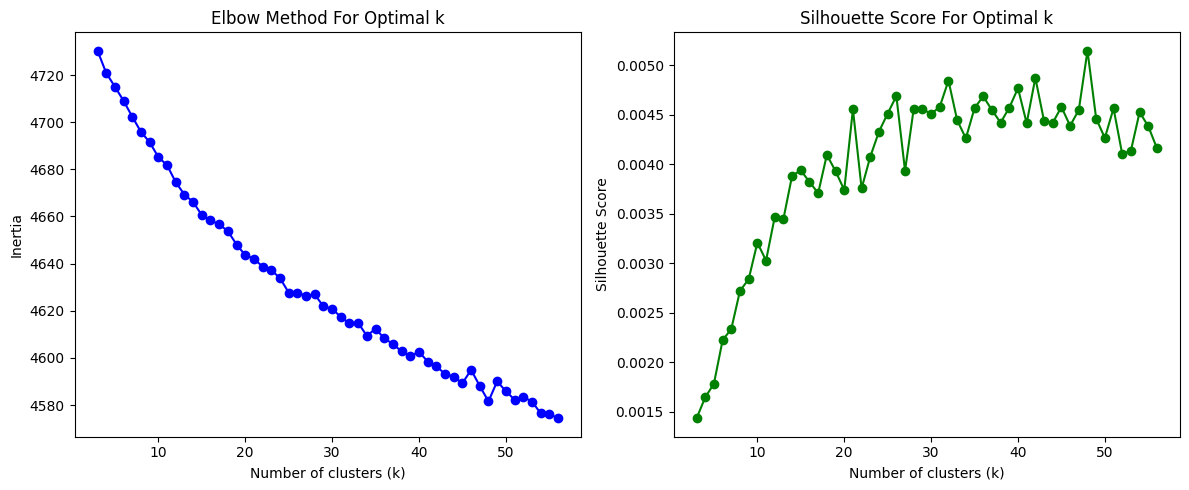

Optimal k based on silhouette score: 48
Clustering complete. Sample cluster distribution:
cluster
3     264
46    236
22    221
6     207
12    196
16    171
7     163
43    161
1     152
39    143
4     119
25    114
38    113
15    112
30    104
33    103
17    100
45     98
27     95
47     93
5      87
32     85
36     82
34     81
41     79
24     77
37     77
0      76
35     74
2      74
40     73
18     72
20     72
26     71
42     62
28     61
14     59
9      58
31     58
11     58
10     57
23     57
44     57
13     54
19     52
21     49
29     40
8      31
Name: count, dtype: int64


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Try different K values to find optimal cluster count
inertia = []
silhouette = []
K_range = range(3, 57)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))

# Visualize Inertia (Elbow Method)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# Visualize Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

# Get best k by silhouette score (maximize it)
optimal_k = K_range[np.argmax(silhouette)]
print(f"Optimal k based on silhouette score: {optimal_k}")

# Final KMeans with optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X)

print("Clustering complete. Sample cluster distribution:")
print(df["cluster"].value_counts())


# Recommendation Logic (Fixed Error: Movies older than 2000 are given recommendations properly)

In [10]:
import ast
from sklearn.metrics.pairwise import cosine_similarity

def has_genre(genres, target):
  return any(d.get('name','').lower() == target.lower() for d in genres)

# def recommend_movies(user_text, user_genre=None, start_year=None, end_year=None, movie_region=None):
def recommend_movies(user_text, user_genre=None, start_year=None, end_year=None, user_tone=None, movie_region=None):

  #1. Parse genres only once (ideally upstream; shown here for clarity)
  if df['genres'].dtype == 'object':
    df['genres_list'] = df['genres'].apply(ast.literal_eval)
  else:
    df['genres_list'] = df['genres']

  if 'release_date' not in df.columns: # Prob can delete this
    raise ValueError("Column 'release_date' not found in df.")

  df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

  # 2. Genre & year filtering
  mask_genre = df['genres_list'].apply(has_genre, target=user_genre)
  mask_year  = df['release_year'].between(start_year, end_year)
  subset = df[mask_genre & mask_year].copy()

  if user_tone:
    mask_tone = df['tone'] == user_tone.lower()
    subset = subset[mask_tone]

  if subset.empty:
    return pd.DataFrame(columns=['original_title', 'overview', 'similarity', 'release_year'])

  # 3. Preprocess & vectorize the user text
  user_tokens = nltk.word_tokenize(user_text)
  user_cleaned = " ".join(preprocess(user_tokens))
  user_vec     = vectorizer.transform([user_cleaned])
  user_cluster = kmeans.predict(user_vec)[0]

  # 4. Restrict to that cluster
  #subset['cluster'] = kmeans.labels_[subset.index]
  #cluster_df = subset[subset['cluster'] == user_cluster].copy()
  cluster_df = subset  # test without clustering

  # 5. Compute cosine similarities
  movie_indices = cluster_df.index
  movie_vecs    = X[movie_indices]

  sims = cosine_similarity(user_vec, movie_vecs).flatten()
  sims_scaled = sims / sims.max()
  cluster_df = cluster_df.assign(similarity=sims_scaled)


  # 7. Sort by similarity and grab top 3
  top3 = (cluster_df.sort_values(by="similarity", ascending=False).head(3))

  return top3[["original_title", "overview", "similarity", "release_year"]]


recommend_movies("Exciting space adventure", "Adventure", 1900, 2080, user_tone="positive")
# Tone options are 'positive', 'neutral', 'negative' based on VADER sentiment classification.

/tmp/ipython-input-10-185383738.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = subset[mask_tone]


,original_title,overview,similarity,release_year
961,The Beach,Twenty-something Richard travels to Thailand a...,1.000000,2000.0
2590,VeggieTales: The Pirates Who Don't Do Anything,Set Sail For Adventure! A boatload of beloved ...,0.715304,2008.0
87,Tomorrowland,"Bound by a shared destiny, a bright, optimisti...",0.641853,2015.0


# Plotting using PCA Plot

In [11]:
from sklearn.decomposition import PCA
import plotly.express as px

# 1. Compute 3D PCA
pca3 = PCA(n_components=3, random_state=42)
X3 = pca3.fit_transform(X.toarray() if hasattr(X, "toarray") else X)

# 2. Build a DataFrame for plotting
df_plot = pd.DataFrame({
    "PC1": X3[:, 0],
    "PC2": X3[:, 1],
    "PC3": X3[:, 2],
    "cluster": df["cluster"].astype(str),
    "title": df["original_title"]
})

# 3. Plot
fig = px.scatter_3d(
    df_plot,
    x="PC1", y="PC2", z="PC3",
    color="cluster",
    hover_name="title",
    title="3D PCA of Movie‑Tone Clusters"
)
fig.update_traces(marker=dict(size=4, opacity=0.7))
fig.show()

# Solution for df.size below:

In [12]:
# df.size - Returns the Total amount of Rows x Columns = 81,566
df.size

print(df.shape)
print("\nDf.shape separates both, so there are only 4,798 rows after preprocessing")
counts = df['tone'].value_counts()
print(counts)

(4798, 17)

Df.shape separates both, so there are only 4,798 rows after preprocessing
tone
negative    1852
positive    1615
neutral     1331
Name: count, dtype: int64


In [13]:
terms = vectorizer.get_feature_names_out()


for i, comp in enumerate(pca3.components_, start=1):
    # pair each term with its loading on PC i
    term_weights = list(zip(terms, comp))
    # sort descending for positive, ascending for negative
    term_weights.sort(key=lambda x: x[1], reverse=True)

    top_pos = term_weights[:10]
    top_neg = term_weights[-10:]

    print(f"PC{i} most POSITIVE words:")
    for term, weight in top_pos:
        print(f"  {term:20} {weight:.4f}")

    print(f"\nPC{i} most NEGATIVE words:")
    for term, weight in top_neg:
        print(f"  {term:20} {weight:.4f}")
    print("\n" + "-"*40 + "\n")

PC1 most POSITIVE words:
  new                  0.2788
  york                 0.2536
  new york             0.2527
  friend               0.1615
  school               0.1475
  love                 0.1431
  life                 0.1328
  new york citi        0.1240
  york citi            0.1240
  citi                 0.1165

PC1 most NEGATIVE words:
  battl                -0.0669
  mission              -0.0744
  team                 -0.0773
  forc                 -0.0924
  ii                   -0.1206
  world war ii         -0.1216
  war ii               -0.1226
  world war            -0.1445
  world                -0.1867
  war                  -0.2229

----------------------------------------

PC2 most POSITIVE words:
  york                 0.3867
  new                  0.3864
  new york             0.3855
  citi                 0.2436
  new york citi        0.2084
  york citi            0.2084
  war                  0.1117
  world                0.1039
  world war            0.0649
 